#   Цель проекта

Я являюсь маркетинговым аналитиком развлекательного приложения Procrastinate Pro+. Компания вкладывает огромные деньги в рекламу, последние несколько месяцев компания терпит убытки. Моя задача — разобраться в причинах и помочь компании выйти в плюс.
Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях,
выгрузка их покупок за этот период,
рекламные расходы.

# Шаг 1. Изучение и предобработка данных


Импортируем библиотеки

In [1]:
import pandas as pd # импорт библиотеки pandas
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import seaborn as sns # импорт библиотеки seaborn
import numpy as np # импорт библиотеки numpy
from scipy import stats as st # импорт библиотеки stats
from datetime import datetime, timedelta # импорт библиотеки datetime

Прочтем файлы при помощи библиотеки Pandas и сохраним в датафреймы

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv', sep=',') # чтение файла с данными и сохранение в sessions
orders = pd.read_csv('/datasets/orders_info_short.csv', sep=',') # чтение файла с данными и сохранение в orders
costs = pd.read_csv('/datasets/costs_info_short.csv', sep=',') # чтение файла с данными и сохранение в ad_costs

Приводим названия столбцов к змеиному регистру

In [3]:
visits = visits.rename(columns={'User Id': 'user_id', 'Region': 'region', 'Device': 'device','Channel': 'channel', 'Session Start': 'session_start', 'Session End': 'session_end'})
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})
costs = costs.rename(columns={'Channel': 'channel'})

Смотрим информацию о датасетах 

In [4]:
visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   

Приводим в нужный формат столбцы

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Проверяем на наличие дубликатов

In [6]:
visits.duplicated().sum()

0

In [7]:
orders.duplicated().sum()

0

In [8]:
costs.duplicated().sum()

0

Узнаем процент пропусков по столбцам

In [9]:
round((visits.isna().mean()*100),2)

user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64

In [10]:
round((orders.isna().mean()*100),2)

user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64

In [11]:
round((costs.isna().mean()*100),2)

dt         0.0
channel    0.0
costs      0.0
dtype: float64

Дубликатов и ппропусков в датафреймах нет, столбцы исправлены к нужному формату. Можно приступать к анализу данных.

# Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии


Создаем функцию создания пользовательских профилей

In [12]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [13]:
profiles = get_profiles(visits, orders,costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Создаем функцию  для  расчёта удержания

In [14]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


Создаем  функцию для расчёта конверсии

In [15]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

Создаем функцию для расчёта LTV и ROI

In [16]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Создаем функцию для сглаживания фрейма

In [17]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Создаем функцию для визуализации удержания

In [18]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

Создаем функцию для визуализации конверсии

In [19]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Создаем функцию  для визуализации LTV и ROI

In [20]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Шаг 3. Исследовательский анализ данных


Определим минимальную и максимальную даты привлечения пользователей

In [21]:
visits.groupby('user_id').agg({'session_start': 'first', 'session_end': 'last'}).rename(columns={'session_end': 'session_last'}).reset_index() #создаем таблицу

,user_id,session_start,session_last
0,599326,2019-05-07 20:58:57,2019-05-09 08:40:06
1,4919697,2019-07-09 12:46:07,2019-07-10 23:00:37
2,6085896,2019-10-01 09:58:33,2019-10-03 10:44:34
3,22593348,2019-08-22 21:35:48,2019-08-22 21:52:45
4,31989216,2019-10-02 00:07:44,2019-10-02 00:20:52
...,...,...,...
150003,999956196527,2019-09-28 08:33:02,2019-09-29 07:30:34
150004,999975439887,2019-10-21 00:35:17,2019-10-27 03:34:51
150005,999976332130,2019-07-23 02:57:06,2019-07-23 03:33:22
150006,999979924135,2019-09-28 21:28:09,2019-10-04 08:44:30


Дата первого привлечения пользователя

In [22]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

Дата последнего привлечения пользователя

In [23]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны

In [24]:
profiles_pivot_region =  profiles.pivot_table(
    index=['region'],
    columns='payer',
    values='user_id',
    aggfunc='count'
) # создаем сводную таблицу  
profiles_pivot_region['all_users'] = profiles.groupby('region').agg({'user_id':'count'})  #  группируем
profiles_pivot_region['ratio'] = round((profiles_pivot_region[1]/profiles_pivot_region['all_users'])*100, 2) # создаем столбец
profiles_pivot_region.sort_values('all_users', ascending=False) # сортируем

payer,False,True,all_users,ratio
region,,,,
United States,93100,6902,100002,6.90
UK,16875,700,17575,3.98
France,16787,663,17450,3.80
Germany,14365,616,14981,4.11


Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [25]:
profiles_pivot_device =  profiles.pivot_table(
    index=['device'],
    columns='payer',
    values='user_id',
    aggfunc='count'
) # создаем сводную таблицу   
profiles_pivot_device['all_users'] = profiles.groupby('device').agg({'user_id':'count'})  #  группируем
profiles_pivot_device['ratio'] = round((profiles_pivot_device[1]/profiles_pivot_device['all_users'])*100, 2) # создаем столбец
profiles_pivot_device.sort_values('all_users', ascending=False) # сортируем

payer,False,True,all_users,ratio
device,,,,
iPhone,51097,3382,54479,6.21
Android,32982,2050,35032,5.85
PC,28918,1537,30455,5.05
Mac,28130,1912,30042,6.36


Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [26]:
profiles_pivot_channel =  profiles.pivot_table(
    index=['channel'],
    columns='payer',
    values='user_id',
    aggfunc='count'
)  # создаем сводную таблицу  
profiles_pivot_channel['all_users'] = profiles.groupby('channel').agg({'user_id':'count'}) #  группируем
profiles_pivot_channel['ratio'] = round((profiles_pivot_channel[1]/profiles_pivot_channel['all_users'])*100, 2) # создаем столбец
profiles_pivot_channel.sort_values('all_users', ascending=False) # сортируем

payer,False,True,all_users,ratio
channel,,,,
organic,55279,1160,56439,2.06
FaceBoom,25587,3557,29144,12.20
TipTop,17683,1878,19561,9.60
OppleCreativeMedia,8372,233,8605,2.71
LeapBob,8291,262,8553,3.06
WahooNetBanner,8100,453,8553,5.30
RocketSuperAds,4096,352,4448,7.91
MediaTornado,4208,156,4364,3.57
YRabbit,4147,165,4312,3.83


# Шаг 4. Маркетинг



Выясним, как траты распределены по источникам

In [27]:
profiles_pivot_channel['total_costs'] = costs.groupby('channel').agg({'costs':'sum'}) # группируем
profiles_pivot_channel.sort_values('total_costs', ascending=False) # сортируем

payer,False,True,all_users,ratio,total_costs
channel,,,,,
TipTop,17683,1878,19561,9.60,54751.30
FaceBoom,25587,3557,29144,12.20,32445.60
WahooNetBanner,8100,453,8553,5.30,5151.00
AdNonSense,3440,440,3880,11.34,3911.25
OppleCreativeMedia,8372,233,8605,2.71,2151.25
RocketSuperAds,4096,352,4448,7.91,1833.00
LeapBob,8291,262,8553,3.06,1797.60
lambdaMediaAds,1924,225,2149,10.47,1557.60
MediaTornado,4208,156,4364,3.57,954.48


Посчитаем общую сумму расходов на маркетинг.

In [28]:
profiles_pivot_channel['total_costs'].sum()

105497.30000000005

Визуализируем изменения расходов компании во времени

Text(0, 0.5, 'Расходы')

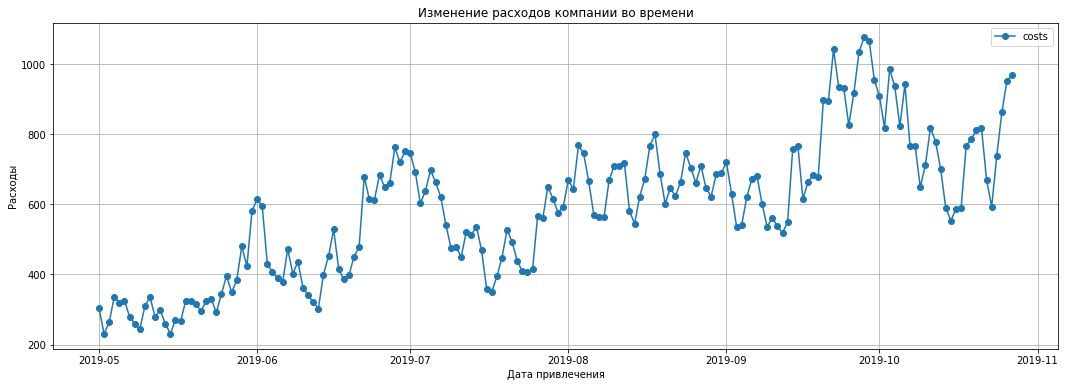

In [29]:
dynamic = costs.pivot_table(index='dt', values='costs', aggfunc='sum')  # создаем сводную  таблицу
dynamic.plot(grid=True, style='o-', figsize=(18,6)) # строим график
plt.title('Изменение расходов компании во времени')
plt.xlabel('Дата привлечения')
plt.ylabel('Расходы')

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника

In [30]:
profiles.groupby('channel').agg({ 'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost', ascending=False) # создаем таблицу

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Рассчитаем средний CAC для всего проекта

In [31]:
new_profiles = profiles.query('channel != "organic"') # исключаем органических пользователей 
new_profiles['acquisition_cost'].mean() # находим среднее

1.1274813239427588

Построим график истории изменений CAC по каналам привлечения

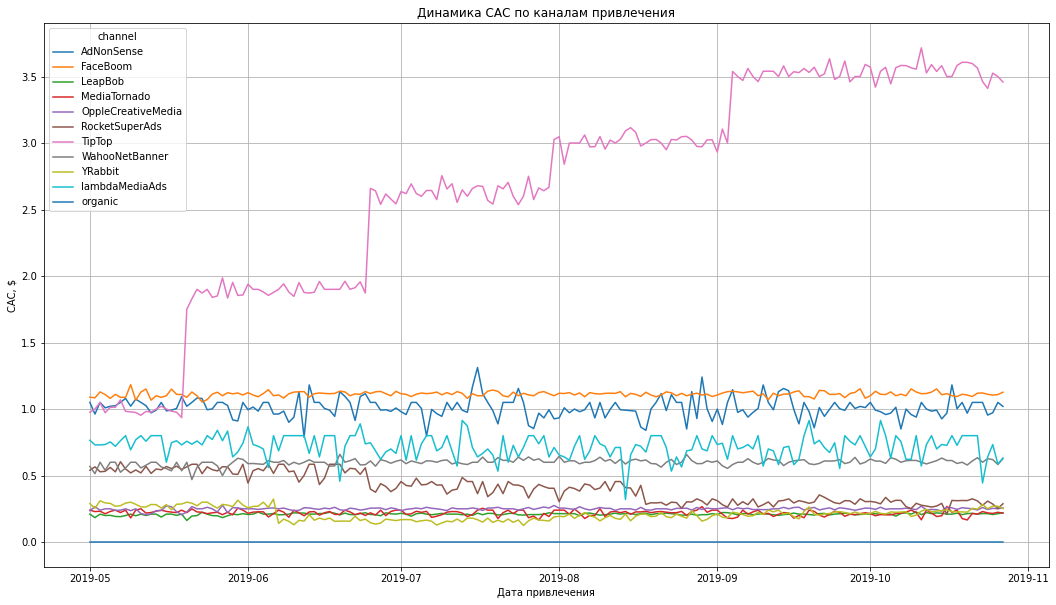

In [32]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(18, 10))   # строим линейный график динамики изменеия CAC 
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

По графикам видно, что затраты на рекламу увеличились в октябре 2019 года по сравнению с  другими месяцами. А так же видно, что стоимость привлечения пользователя (САС) через Tip Toр сильно больше чем на других каналах

# Шаг 5. Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

Установим момент и горизонт анализа данных. Сейчас на календаре 1 ноября 2019 года, и зададим двухнедельный горизонт анализа.

In [33]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

### Проанализируем общую окупаемость рекламы

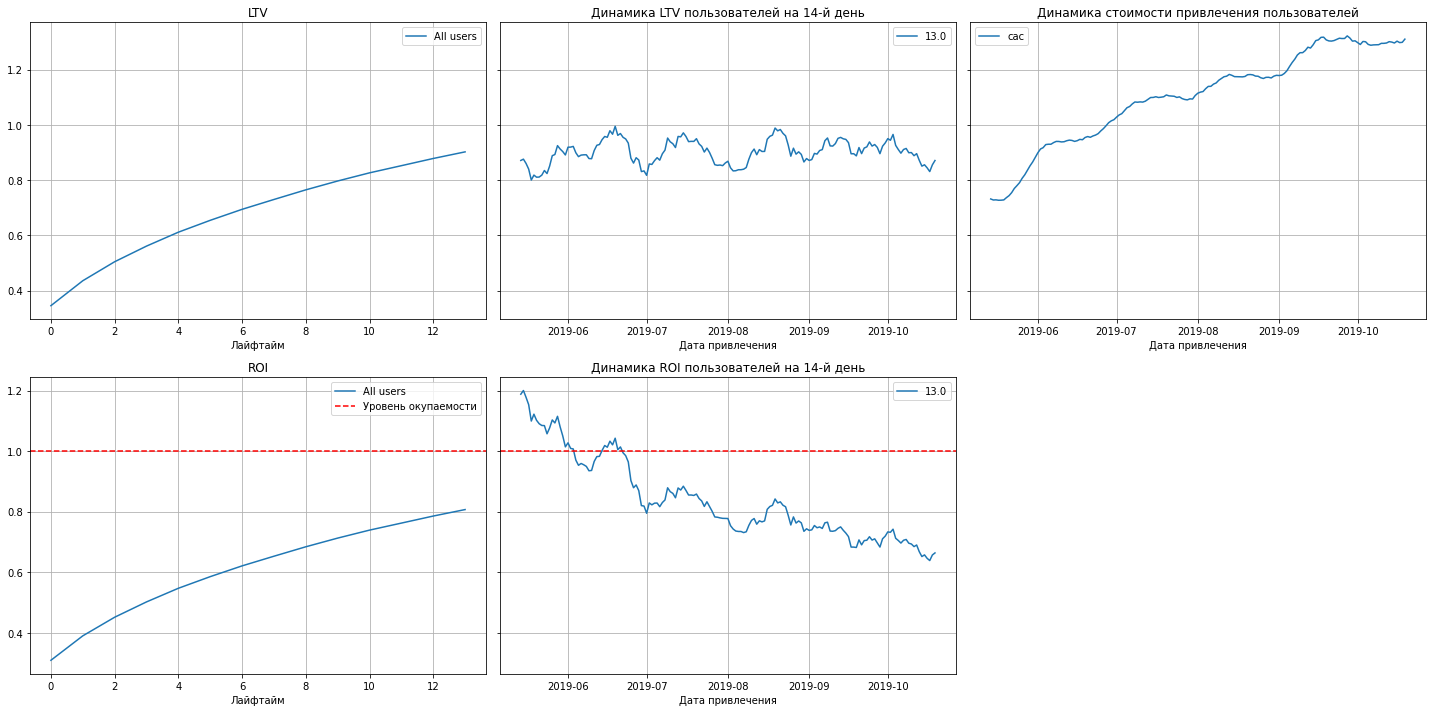

In [34]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
- Реклама не окупается. ROI стремительно падает с июня месяца.
- CAC  не стабилен. Рекламный бюджет увеливается  с каждым  месяцем.
- На LTV влияет сезонный фактор, этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

<div class="alert alert-success">
  
  <b>Комментарий ревьюера v.2</b>
    
  ✔️ Да, наблюдаем явные проблемы.
</div>

### Проанализируем окупаемость рекламы с разбивкой по устройствам

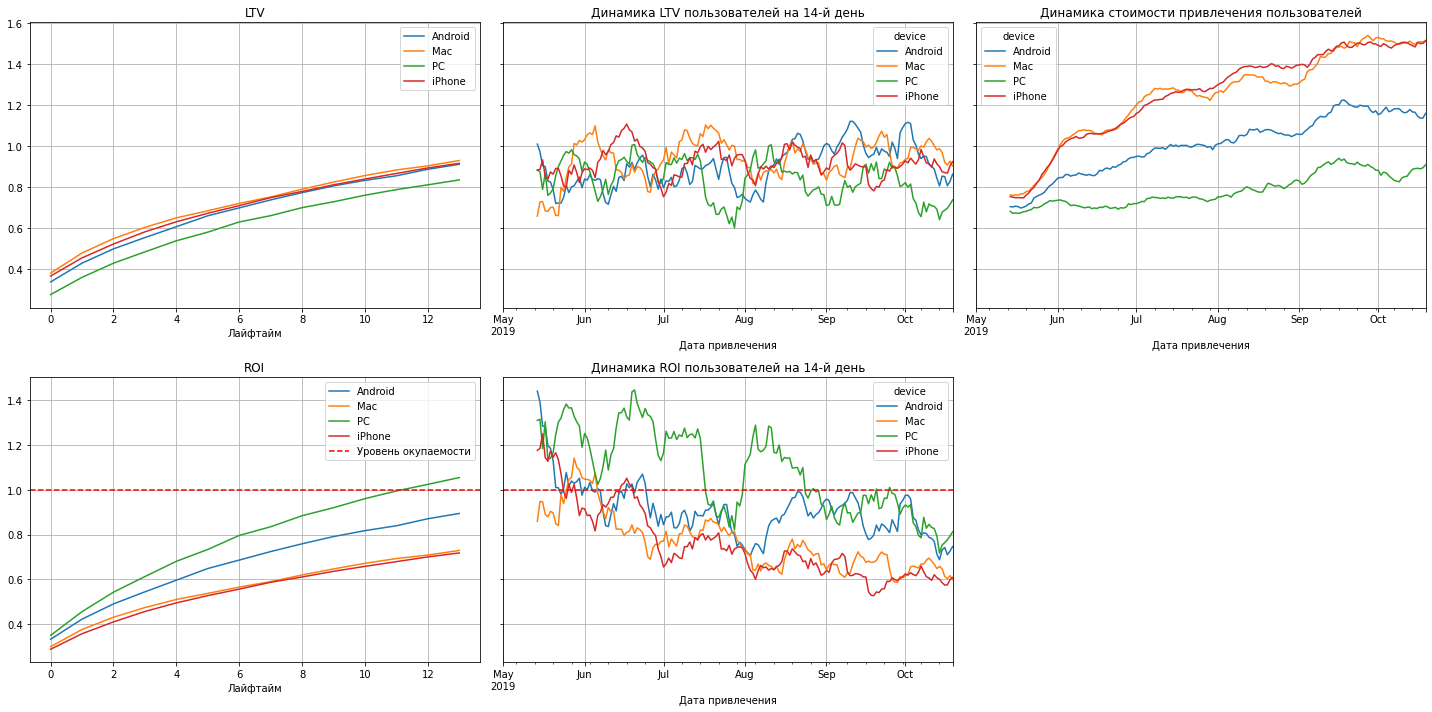

In [35]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Разбивка по устройствам  говорит  нам   следующее:
- Реклама не окупается  для  всех устройств, динамика схожая
- Стоимость привлечения стабильно растет не в  зависимости от типа устройства
- LTV подвержен сезонности, характер графиков одинаков
- PC к концу 2 недели окупается.

По графикам видно, что окупаемость   рекламы  снижается, но проблема явно не в устройствах.

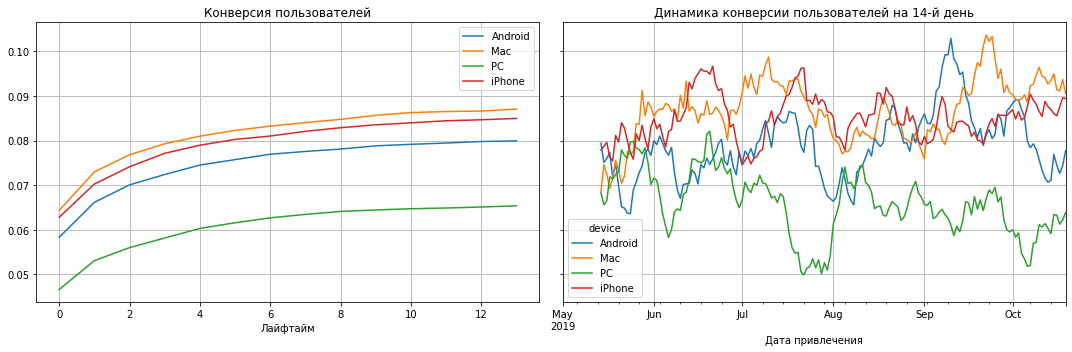

In [36]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    new_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

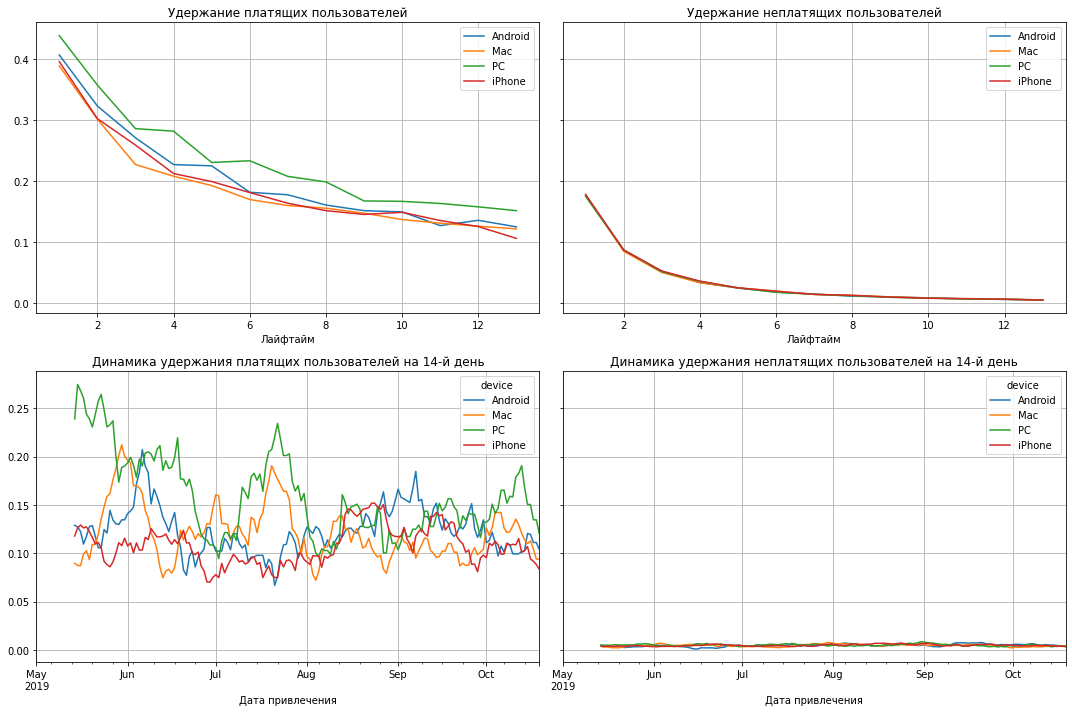

In [37]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Пользователи PC хуже всего конвертриуются, зато лучше удерживаются

### Проанализируем окупаемость рекламы с разбивкой по странам

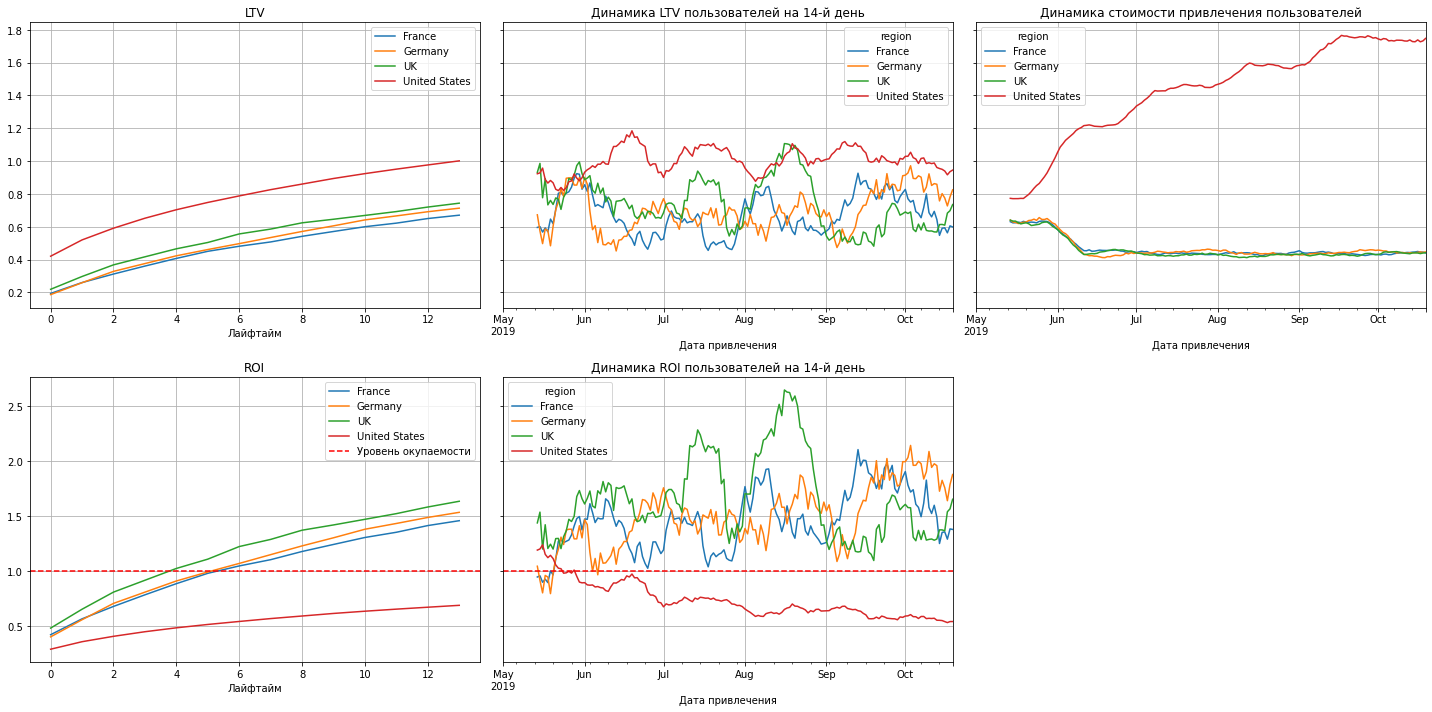

In [38]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Разбивка по странам отчетливо раскрывает нам глаза.
Вот что говорят графики:
- Реклама не окупается в United States.
- Стоимость привлечения очень высока и стабильно растет для пользователей из United States
- LTV всё так же подвержен сезонности, но стабилен.

Явным аутсайдером является United States с начала лета мы  видим сильный рост в стоимости привлечения клиентов и как следствие упадок в показателе ROI.

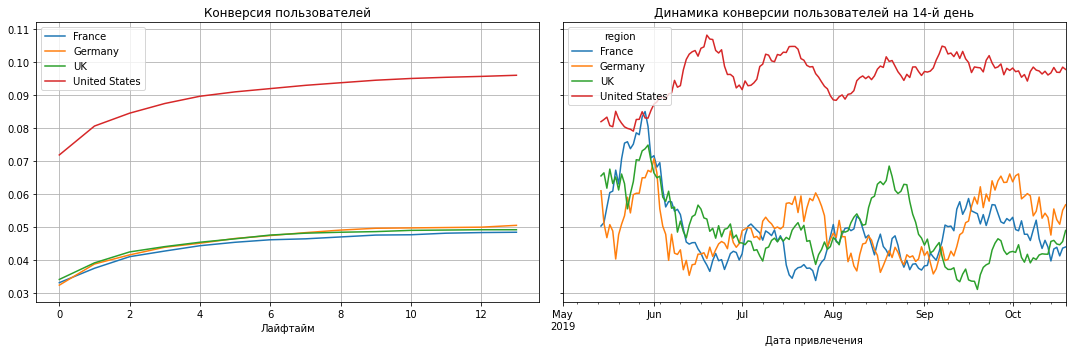

In [39]:
# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    new_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

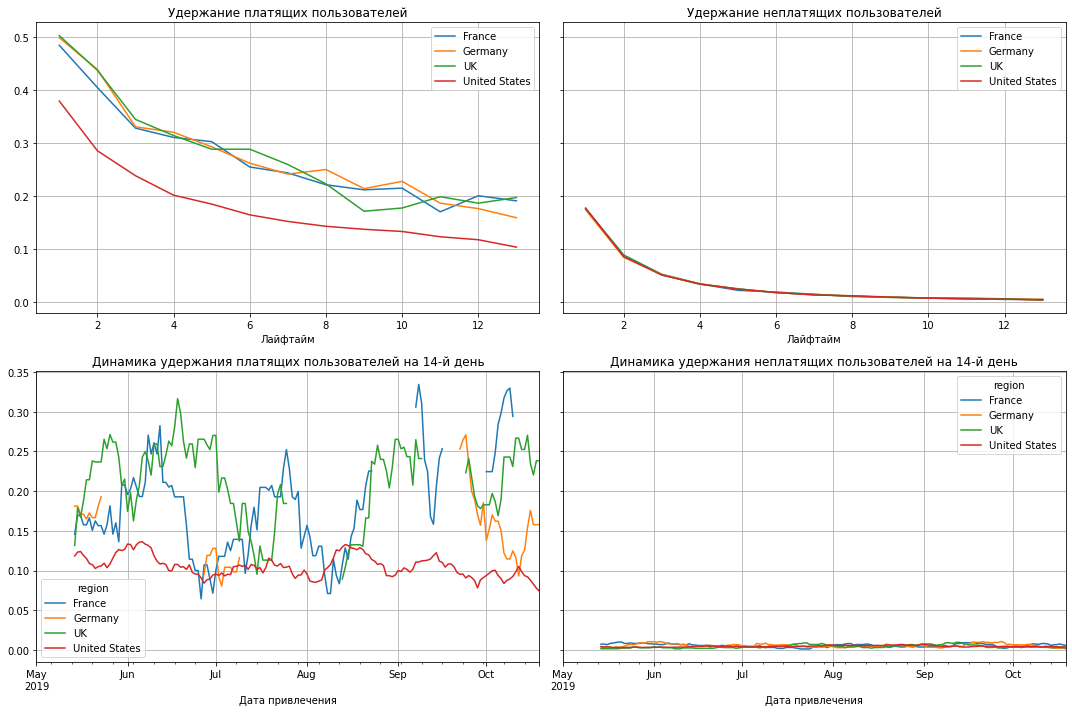

In [40]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

С конверсией у пользователей из Штатов проблем нет, не даром вливаются туда такие деньги, но они не удерживаются и не окупаются. 

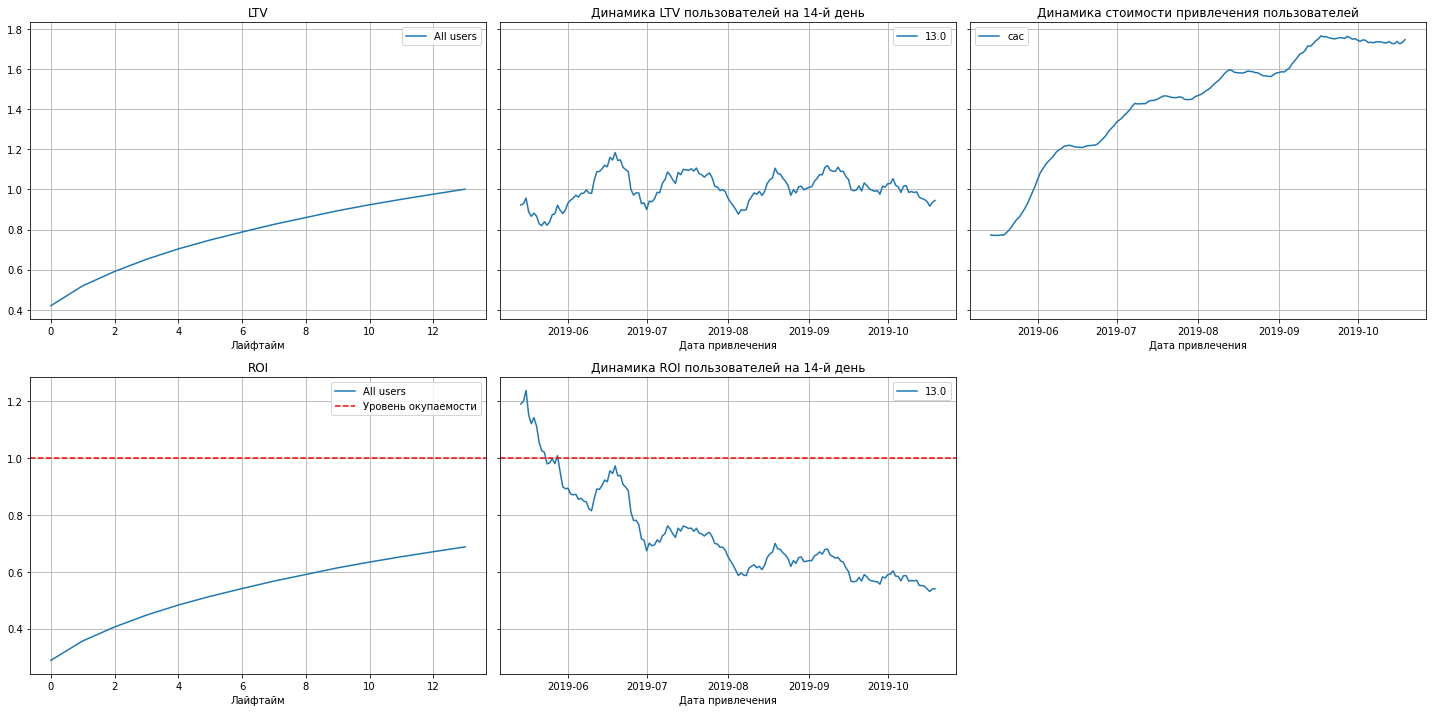

In [41]:
usa_profiles = new_profiles.query('region == "United States"')
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    usa_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

<AxesSubplot:ylabel='region'>

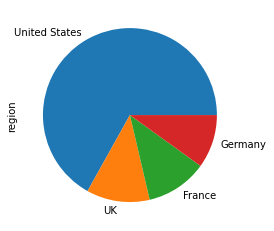

In [42]:
visits['region'].value_counts().plot(kind='pie')

Рекламная кампания в Штатах явно не удалась, затраты на рекламу стабильно растут, а возврат на инвестиции падает. А это львинная доля рынка для Procrastinate Pro+

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

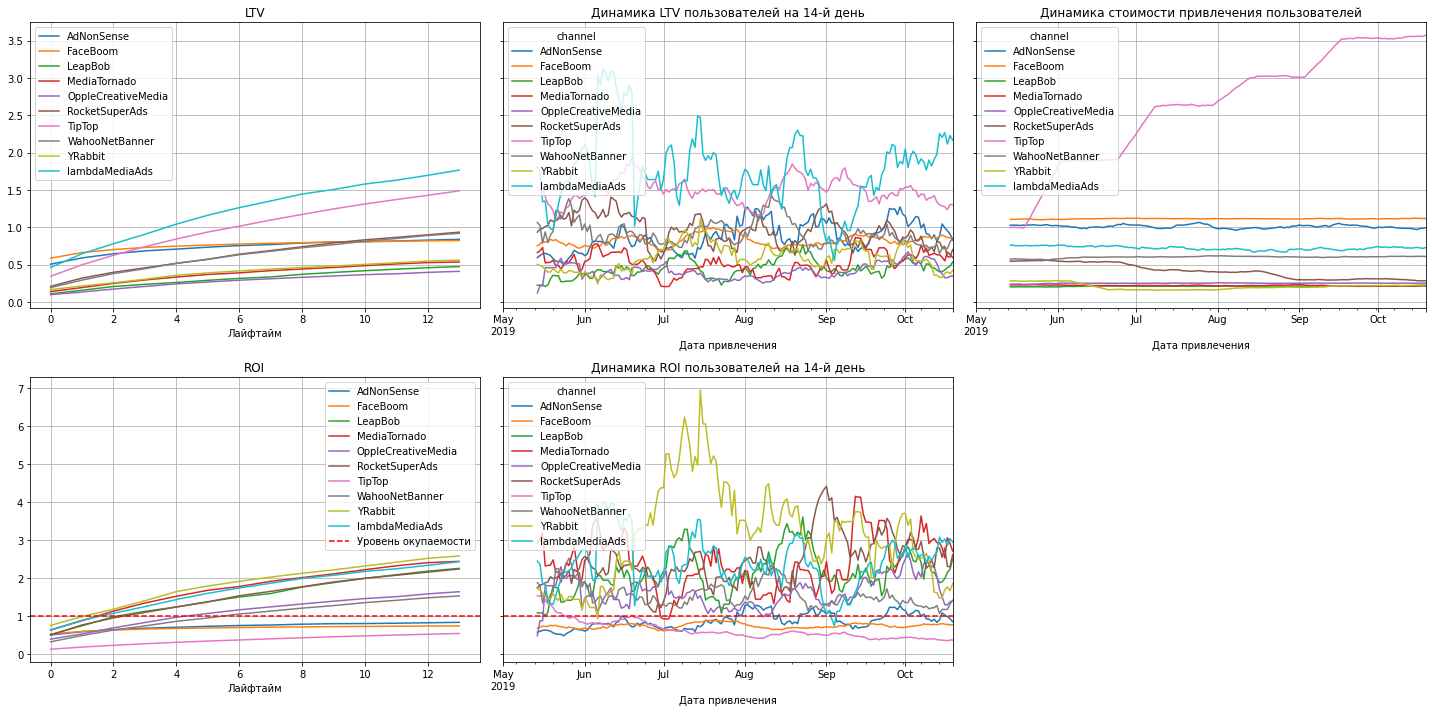

In [43]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    new_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Разбивка по каналам говорит нам  следующее:
- Реклама не окупается для Tip Top, FaceBoom и LambaMediaAds
- Стоимость привлечения очень высока и сильно отрывается  от  всех для Tip Top 
- На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен

Явным аутсайдером является Tip Top мы  видим сильный рост в стоимости привлечения клиентов при помощи этого  канала и как следствие упадок в показателе возврат на инвестиции.

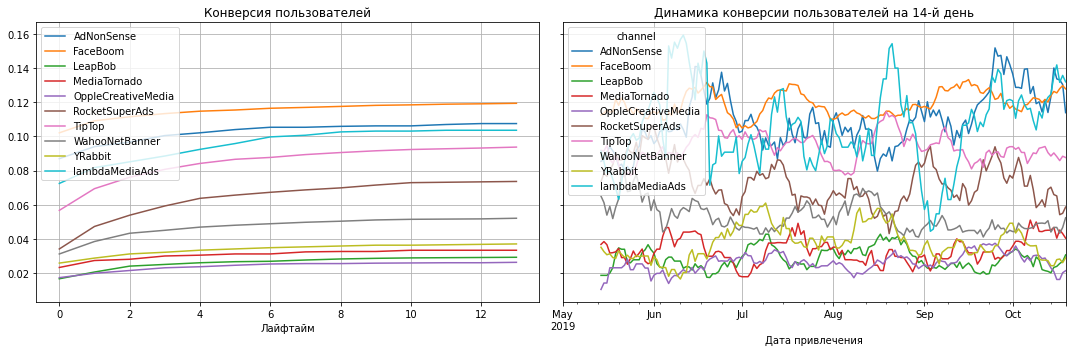

In [44]:
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    new_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

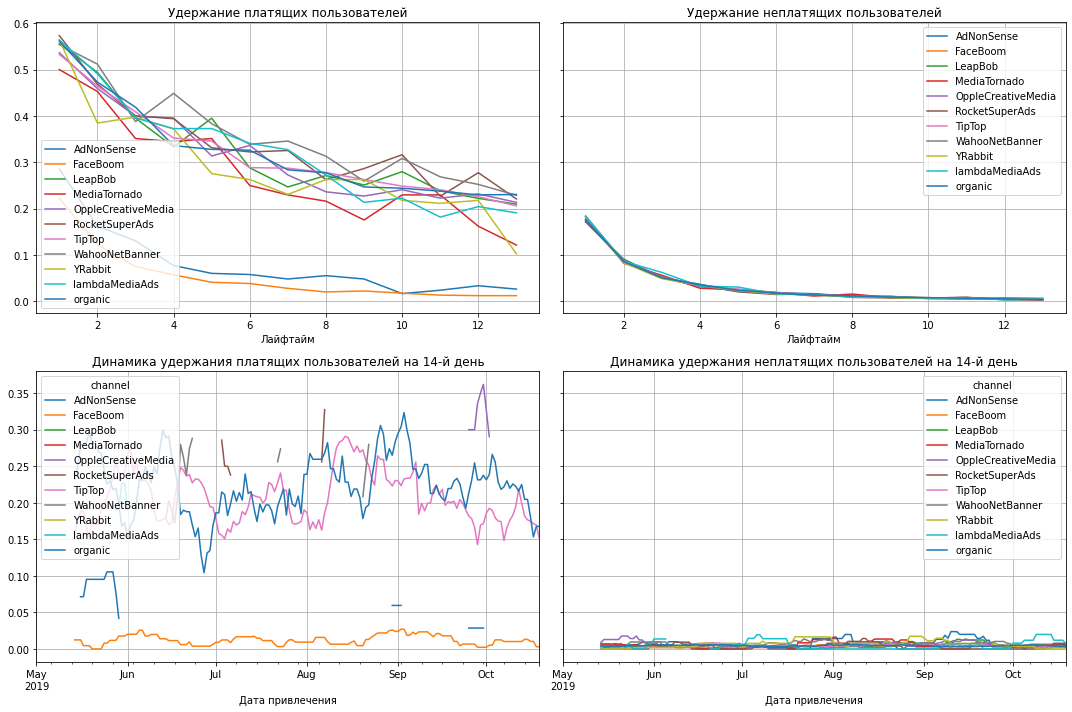

In [45]:
# смотрим удержание с разбивкой по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Плохие показатели удержания у FaceBoom и AdNonSense

# Шаг 6. Общий вывод



Развлекательное приложения Procrastinate Pro+ делает огромные вложения в рекламу и терпит убытки из за неправильной рекламной кампании.  Проблема состоит в том, что большие стредства направляются в канал привлечения Tip Top. А так же для FaceBoom и LambaMediaAds. Мы явно видим из графиков, что стоимость привлечения из United States гораздо больше чем из других стран, а это огромная доля рынка приложения. У канала FaceBoom проблемы с удержанием, так же как и у всего рынка США.

Маркетинговому отделу Procrastinate Pro+ следует сократить рекламный бюджет для Штатов и немного его оптимизировать по каналам. Следует распределить расходы с каналов Tip Top и FaceBoom например на: RocketSuperAds, WahooNetBanner, где хороший показатель как конверсии, так и удежания. А вот для Европейского рынка следует увеличить расходы на маркетинг, чтобы и дальше получать прибыль. Стоит разобраться с удержанием для канала AdNonSense, возможно отказаться от него. Для Европейской аудитории приложение Procrastinate Pro+ пользуется отличным спросом. Показатель ROI для всех стран Европы выше единицы, так же хорошие показатели конверсии и удержания.   